In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

from IPython.display import set_matplotlib_formats
set_matplotlib_formats('png', 'pdf')

import numpy as np
import matplotlib.pyplot as plt
import quantities as pq
from operator import itemgetter
from edog.tools import*
from edog.plot import*
plt.style.use('seaborn')
plt.rcParams.update(edog.plot.params)

filename = "params.yaml"
params = parse_parameters(filename)

nt, nr, dt, dr = itemgetter("nt", "nr", "dt", "dr")(params["grid"])
k_id, temporal_freq = itemgetter("k_id", "w")(params["stimulus"])
angular_freq = temporal_freq * 2 * np.pi

A_g, a_g, B_g, b_g = itemgetter("A", "a", "B", "b")(params["ganglion"])
phase, damping, delay_g = itemgetter("phase", "damping", "delay")(params["ganglion"])

w_rg, A_rg, a_rg = itemgetter("w", "A", "a")(params["relay"]["Krg"])
tau_rg, delay_rg = itemgetter("tau", "delay")(params["relay"]["Krg"])

w_rig, A_rig, a_rig = itemgetter("w", "A", "a")(params["relay"]["Krig"])
tau_rig, delay_rig = itemgetter("tau", "delay")(params["relay"]["Krig"])

w_rc_ex, A_rc_ex, a_rc_ex = itemgetter("w", "A", "a")(params["relay"]["Krc_ex"])
tau_rc_ex, delay_rc_ex = itemgetter("tau", "delay")(params["relay"]["Krc_ex"])

w_rc_in, A_rc_in, a_rc_in = itemgetter("w", "A", "a")(params["relay"]["Krc_in"])
tau_rc_in, delay_rc_in = itemgetter("tau", "delay")(params["relay"]["Krc_in"])

w_rc_mix = itemgetter("w")(params["relay"]["Krc_mix"])
A_rc_mix_in, a_rc_mix_in = itemgetter("A", "a")(params["relay"]["Krc_mix"]["Krc_in"])
tau_rc_mix_in = itemgetter("tau")(params["relay"]["Krc_mix"]["Krc_in"])
A_rc_mix_ex, a_rc_mix_ex = itemgetter("A", "a")(params["relay"]["Krc_mix"]["Krc_ex"])
tau_rc_mix_ex = itemgetter("tau")(params["relay"]["Krc_mix"]["Krc_ex"])


delayed_in, synced, delayed_ex = itemgetter("delayed_in", "synced", "delayed_ex")(params["relay"]["Krc_mix"])

## Excitatory and inhibitory feedback

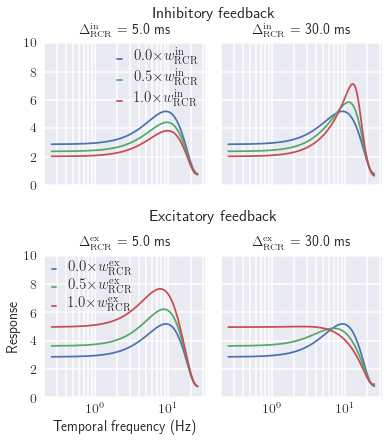

In [2]:
label_in = r"$w^\mathrm{in}_{\mathrm{RCR}}$"
delay_label_in = r"$\Delta_\mathrm{RCR}^\mathrm{in}$"
label_ex = r"$w^\mathrm{ex}_{\mathrm{RCR}}$"
delay_label_ex = r"$\Delta_\mathrm{RCR}^\mathrm{ex}$"

fig, axarr = plt.subplots(nrows=2, ncols=2, figsize=(5.5, 6.0), sharey="all", sharex="all")

plt.figtext(0.55, 0.999, "Inhibitory feedback", ha='center', va='center', fontsize=16)
plt.figtext(0.55, 0.53, "Excitatory feedback", ha='center', va='center', fontsize=16)


for i, delay in enumerate(delay_rc_in):
    ax = axarr[0, i]
    for w in w_rc_in:
        network = create_spatiotemporal_network(nt=nt, nr=nr, dt=dt, dr=dr,
                                                A_g=A_g, a_g=a_g, B_g=B_g, b_g=b_g,
                                                phase=phase, damping=damping, delay_g=delay_g,
                                                w_rg=w_rg, A_rg=A_rg, a_rg=a_rg,
                                                tau_rg=tau_rg, delay_rg=delay_rg,
                                                w_rig=w_rig, A_rig=A_rig, a_rig=a_rig,
                                                tau_rig=tau_rig, delay_rig=delay_rig,
                                                w_rc_in=w, A_rc_in=A_rc_in, a_rc_in=a_rc_in,
                                                tau_rc_in=tau_rc_in, delay_rc_in=delay)
        [relay] = get_neuron("Relay", network)
        wavenumber = network.integrator.spatial_angular_freqs[int(k_id)]
        tuning = relay.evaluate_irf_ft(angular_freq.rescale(1/pq.ms), wavenumber, 0/pq.deg)
        tuning = np.absolute(tuning)

        title = "{} = {}".format(delay_label_in, round(delay, 1))

        ax.semilogx(temporal_freq, tuning, label=r"${} \times$".format(round(w, 1))+label_in)
        ax.set_title(title, fontsize=14, linespacing=1.7)
        ax.grid(which="both", lw=1.5)

axarr[0, 0].legend(fontsize=15, handlelength=0.3, labelspacing=0.3, borderpad=0.0)
     
        

        
for i, delay in enumerate(delay_rc_ex):
    ax = axarr[1, i]
    for w in w_rc_ex:
        network = create_spatiotemporal_network(nt=nt, nr=nr, dt=dt, dr=dr,
                                                A_g=A_g, a_g=a_g, B_g=B_g, b_g=b_g,
                                                phase=phase, damping=damping, delay_g=delay_g,
                                                w_rg=w_rg, A_rg=A_rg, a_rg=a_rg,
                                                tau_rg=tau_rg, delay_rg=delay_rg,
                                                w_rig=w_rig, A_rig=A_rig, a_rig=a_rig,
                                                tau_rig=tau_rig, delay_rig=delay_rig,
                                                w_rc_ex=w, A_rc_ex=A_rc_ex, a_rc_ex=a_rc_ex,
                                                tau_rc_ex=tau_rc_ex, delay_rc_ex=delay)
        [relay] = get_neuron("Relay", network)
        wavenumber = network.integrator.spatial_angular_freqs[int(k_id)]
        tuning = relay.evaluate_irf_ft(angular_freq.rescale(1/pq.ms), wavenumber, 0/pq.deg)
        tuning = np.absolute(tuning)

        title = "{} = {}".format(delay_label_ex, round(delay, 1))

        ax.semilogx(temporal_freq, tuning, label=r"${} \times$".format(round(w, 1))+label_ex)
        ax.set_title(title, fontsize=14, linespacing=1.7)
        ax.grid(which="both", lw=1.5)

axarr[1, 0].set_xlabel("Temporal frequency (Hz)")
axarr[1, 0].set_ylabel("Response")
axarr[1, 0].set_ylim([0, 10])
#axarr[1, 0].set_yticks([0, 1, 2, 3, 4])
axarr[1, 0].legend(fontsize=15, handlelength=0.3, labelspacing=0.3, borderpad=0.0)

plt.tight_layout()
fig.subplots_adjust(hspace=0.5, wspace=0.1)

## Mixed excitatory and inhibitory feedback

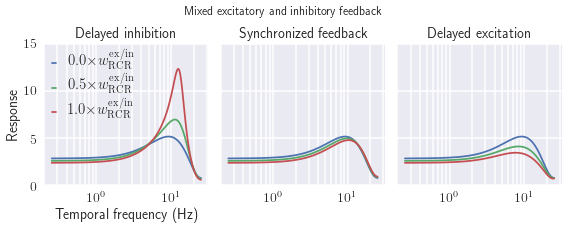

In [3]:
titles = ["Delayed inhibition", "Synchronized feedback", "Delayed excitation"]
label = r"$w^\mathrm{ex/in}_{\mathrm{RCR}}$"

fig, axarr = plt.subplots(nrows=1, ncols=3, figsize=(8, 3), sharey="all", sharex="all")
fig.suptitle("Mixed excitatory and inhibitory feedback", y=1.05)

for ax, title, params in zip(axarr.flat, titles, [delayed_in, synced, delayed_ex]):
    for w in w_rc_mix:
        network = create_spatiotemporal_network(nt=nt, nr=nr, dt=dt, dr=dr,
                                                A_g=A_g, a_g=a_g, B_g=B_g, b_g=b_g,
                                                phase=phase, damping=damping, delay_g=delay_g,
                                                w_rg=w_rg, A_rg=A_rg, a_rg=a_rg,
                                                tau_rg=tau_rg, delay_rg=delay_rg,
                                                w_rig=w_rig, A_rig=A_rig, a_rig=a_rig,
                                                tau_rig=tau_rig, delay_rig=delay_rig,
                                                w_rc_ex=w, A_rc_ex=A_rc_mix_ex, a_rc_ex=a_rc_mix_ex,
                                                tau_rc_ex=tau_rc_mix_ex, delay_rc_ex=params["delay_ex"],
                                                w_rc_in=w, A_rc_in=A_rc_mix_in, a_rc_in=a_rc_mix_in,
                                                tau_rc_in=tau_rc_mix_in, delay_rc_in=params["delay_in"])
                                                
        [relay] = get_neuron("Relay", network)
        wavenumber = network.integrator.spatial_angular_freqs[int(k_id)]
        tuning = relay.evaluate_irf_ft(angular_freq.rescale(1/pq.ms), wavenumber, 0/pq.deg)
        tuning = np.absolute(tuning)

        ax.semilogx(temporal_freq, tuning, label=r"${} \times$".format(round(w, 1))+label)
        ax.set_title(title, fontsize=14, linespacing=1.7)
        ax.grid(which="both", lw=1.5)

axarr[0].set_xlabel("Temporal frequency (Hz)")
axarr[0].set_ylabel("Response")
axarr[0].set_ylim([0, 15])
axarr[0].legend(fontsize=15, handlelength=0.3, labelspacing=0.3, borderpad=0.)
fig.subplots_adjust(hspace=0.3, wspace=0.1)
plt.tight_layout()